## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
import cvxopt as opt
from cvxopt import blas, solvers
import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
dataset = read_csv('sp500data.csv', index_col = 0)

## Exploratory Data Analisys

In [3]:
dataset.shape

(1681, 502)

In [4]:
set_option('display.width', 100)
dataset.head(5)

,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,61.529999,58.790001,98.410004,153.839996,177.699997,10.98,10.88,43.985001,67.599998,165.509995,...,35.299999,31.139999,146.990005,164.300003,47.810001,68.070000,81.599998,103.709999,120.446602,71.769997
2018-01-03 00:00:00,61.900002,58.919998,99.949997,154.550003,181.039993,11.55,10.87,44.115002,69.320000,166.410004,...,35.610001,32.000000,149.740005,162.520004,47.490002,68.900002,81.529999,105.769997,121.281555,72.099998
2018-01-04 00:00:00,62.189999,58.820000,99.379997,156.380005,183.220001,12.12,10.83,44.570000,68.800003,167.050003,...,35.320000,32.549999,151.259995,163.399994,47.119999,69.360001,82.360001,107.860001,121.106796,72.529999
2018-01-05 00:00:00,62.990002,58.990002,101.110001,157.669998,185.339996,11.88,10.87,44.865002,69.900002,168.449997,...,35.270000,32.459999,152.229996,164.490005,46.790001,69.230003,82.839996,109.540001,122.310677,73.360001
2018-01-08 00:00:00,63.290001,58.820000,99.489998,158.929993,185.039993,12.28,10.87,44.980000,70.050003,168.630005,...,35.500000,32.580002,151.410004,162.300003,47.139999,69.480003,82.980003,110.629997,122.543686,74.239998


## Data Preparation

### Data Cleaning

In [5]:
# Remove columns with more than 30% missing values
if(dataset.isnull().values.any()):
    missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
    dataset = dataset.drop(labels=drop_list, axis=1)
    # Fill the missing values with the last value available
    dataset = dataset.ffill()
    print(dataset.shape)

(1681, 490)


### Data Transformation

In [6]:
# Create training dataset with 80% of in-samples
X = dataset.copy(deep=True)
rows = len(X)
train_len = int(rows * 0.8)
X_train = X.head(train_len)
X_test = X.tail(rows - train_len)
# Create returns dataset for algorithms
df_ret_train = X_train.pct_change().dropna()
df_ret_test  = X_train.pct_change().dropna()

## Evaluate Algorithms and Models

In [7]:
# Compute correlation
def correlDist(corr):
    dist = ((1 - corr) / 2.0) ** 0.5
    return dist
# Calculate linkage
dist = correlDist(df_ret_train.corr())
link = linkage(dist, 'ward')
print(link[0])

[17.         18.          0.08450236  2.        ]


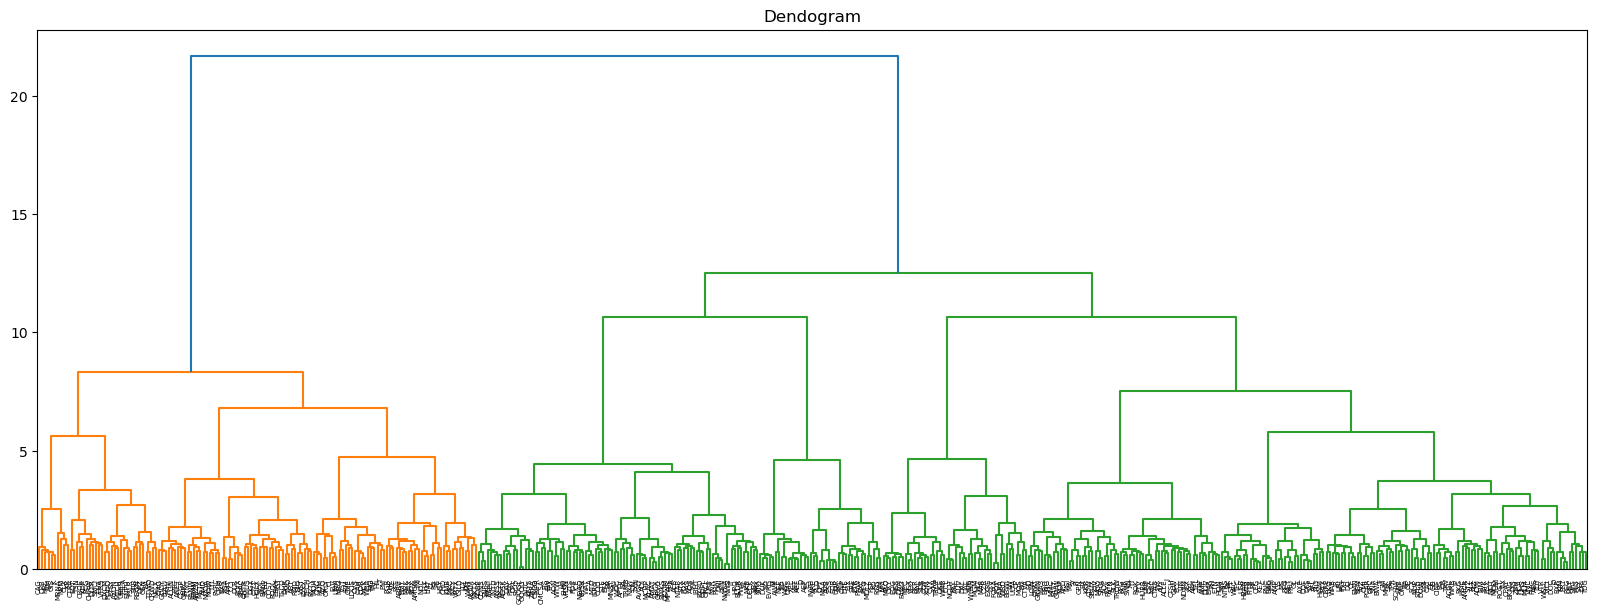

In [8]:
# Plot dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendogram")
dendrogram(link, labels = X.columns)
plt.show()

### Hierarchial Risk Parity

In [13]:
# Quasi-diagonalization and getting the weights
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0] # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sortIx = pd.concat([sortIx, df0]) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()
# Recursive bisection
def getIVP(cov, **kargs):
    # compute the inverse-variance portfolio
    ivp = 1.0 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp
def getClusterVar(cov, cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems, cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx] # initializa all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1] # bi-section
        for i in range(0, len(cItems), 2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i + 1] # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1 - alpha # weight 2
    return w
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

### Markowitz's Minimum-Variance Portfolio

In [10]:
def getMVP(cov):
    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]
    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    pbar = opt.matrix(np.ones(cov.shape[0]))
    # Create constraint matrices
    G = -opt.matrix(np.eye(n)) # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b) ['x'] for mu in mus]
    # Calculate risk and returns for frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    # Calculate the 2nd degree polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return list(wt)

In [11]:
# Getting the portfolio weights for all types of asset allocation
def get_all_portfolios(returns):
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index= cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    return portfolios

## Plotting portfolios

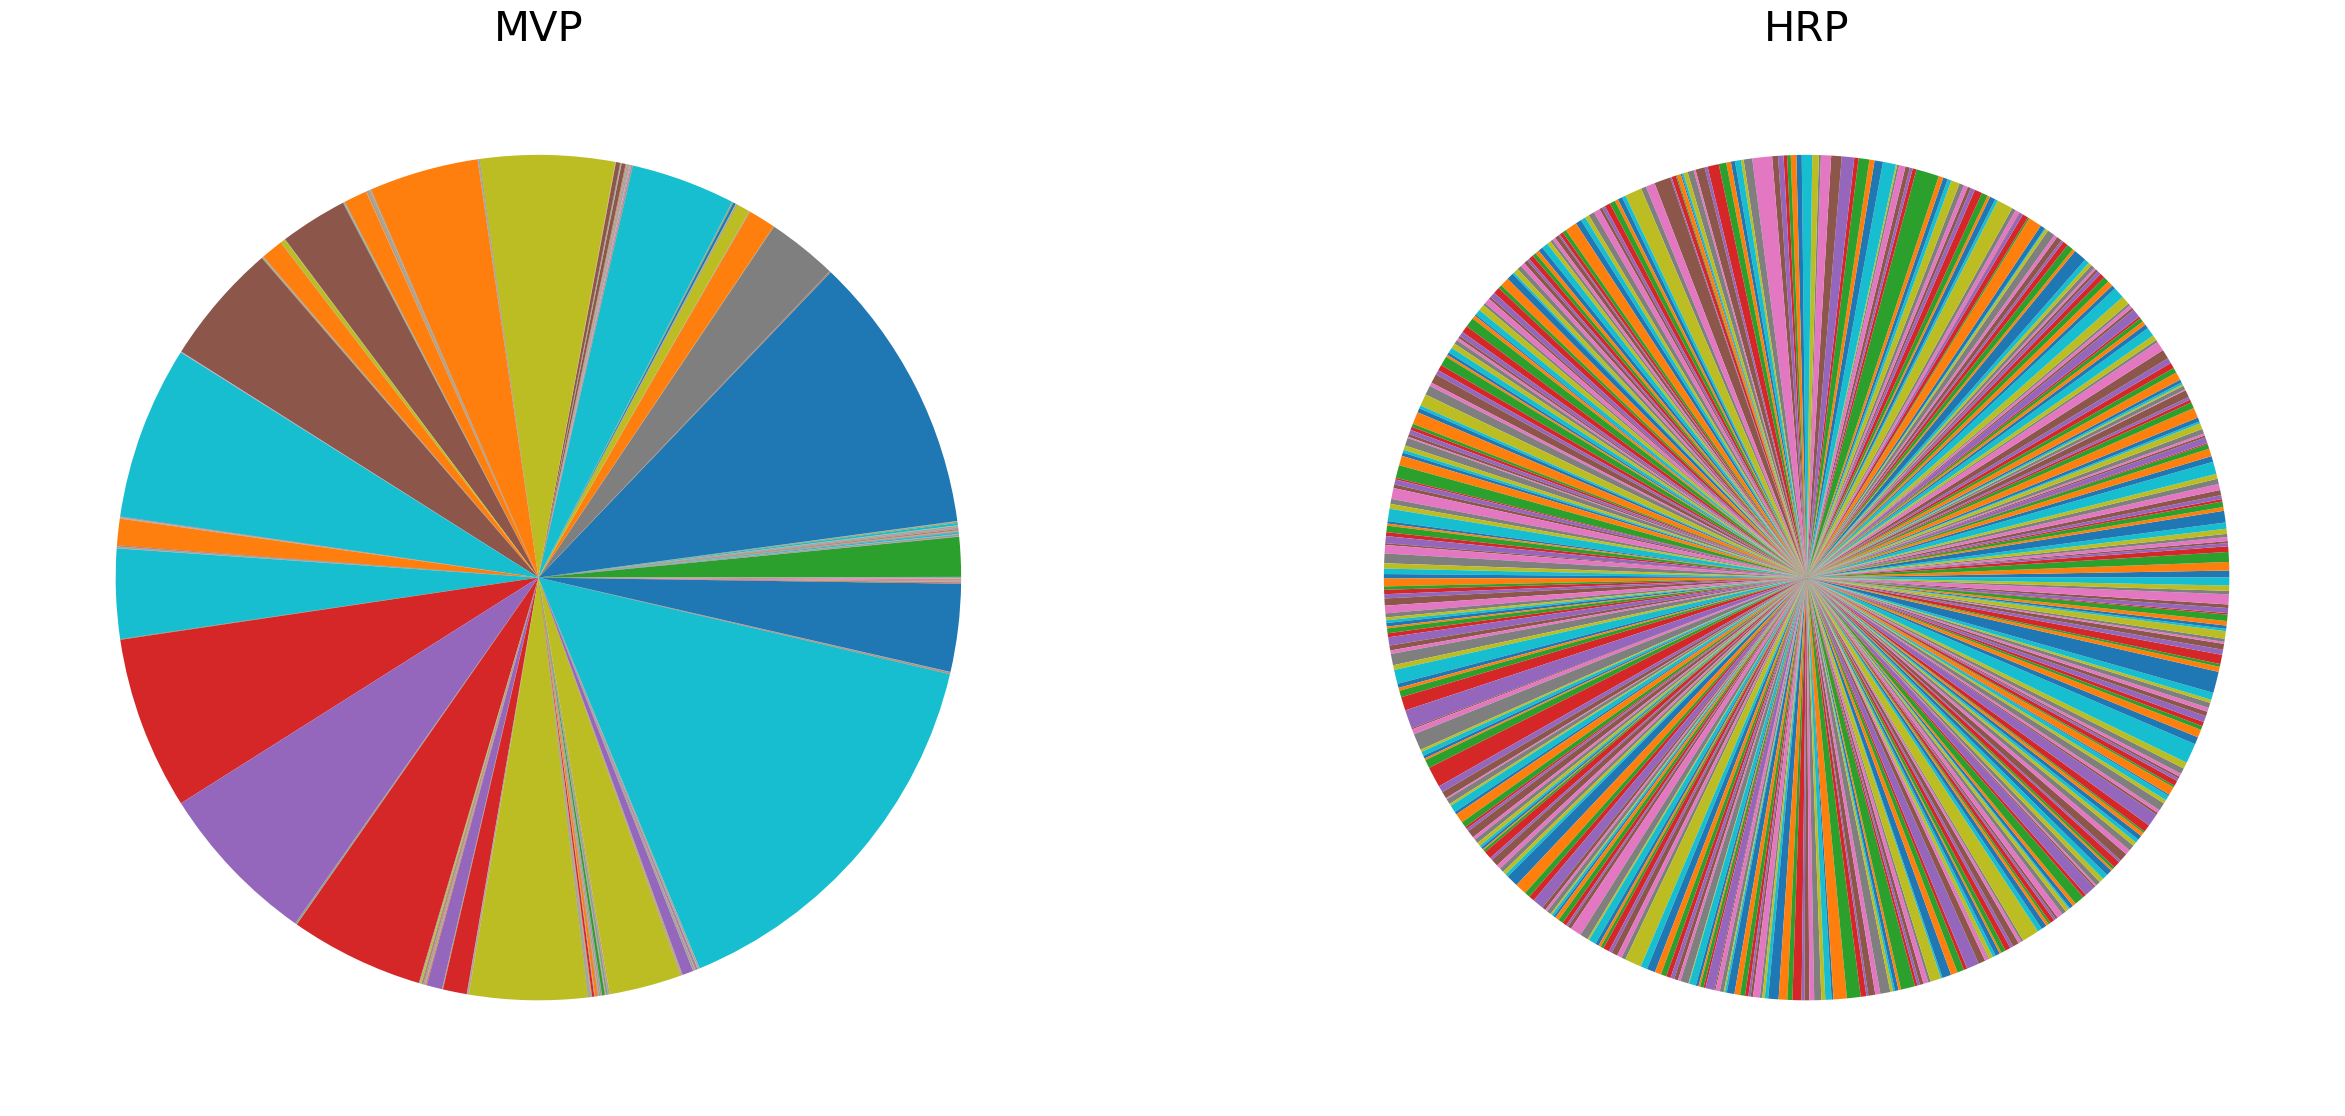

In [14]:
# Get HRP and MVP portfolios
portfolios = get_all_portfolios(df_ret_train)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20))
ax1.pie(portfolios.iloc[:, 0])
ax1.set_title('MVP', fontsize=30)
ax2.pie(portfolios.iloc[:, 1])
ax2.set_title('HRP', fontsize=30)
plt.show()

## Backtesting in OOS

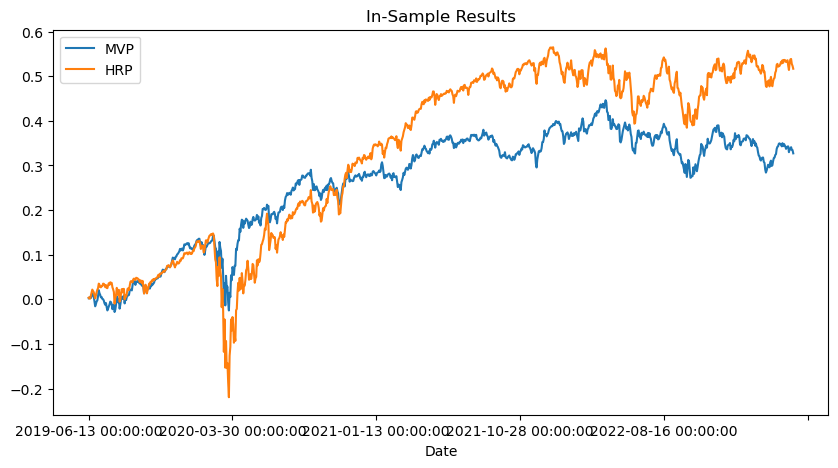

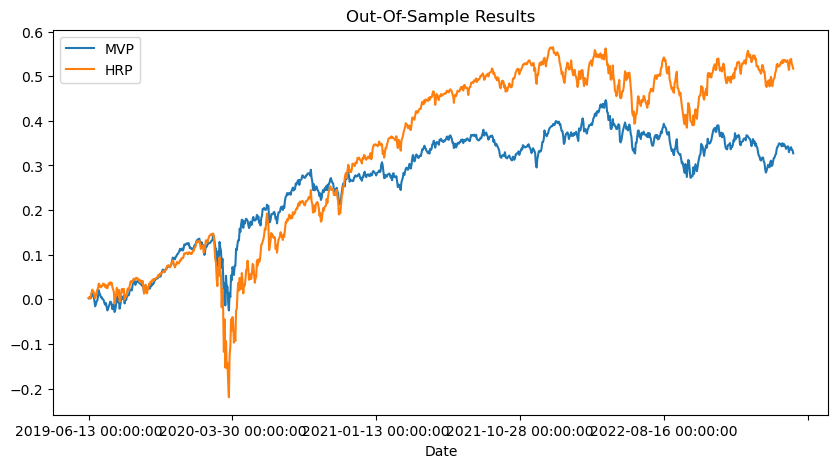

In [15]:
# Plotting IS and OOS results
InSample_Result = pd.DataFrame(np.dot(df_ret_train, np.array(portfolios)),
                               columns=['MVP', 'HRP'], index=df_ret_train.index)
OutOfSample_Result = pd.DataFrame(np.dot(df_ret_test, np.array(portfolios)),
                                  columns=['MVP', 'HRP'], index=df_ret_test.index)
InSample_Result.cumsum().plot(figsize=(10, 5), title='In-Sample Results')
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title='Out-Of-Sample Results')
plt.show()

In [16]:
# Print IS statistics
stddev_is = InSample_Result.std() * np.sqrt(252)
sharp_ratio_is = (InSample_Result.mean() * np.sqrt(252)) / InSample_Result.std()
df_is_stats = pd.DataFrame(dict(stdev=stddev_is, sharp_ratio=sharp_ratio_is))
df_is_stats


,stdev,sharp_ratio
MVP,0.145683,0.576975
HRP,0.209125,0.634883


In [17]:
# Print OOS statistics
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean() * np.sqrt(252)) / OutOfSample_Result.std()
df_oos_stats = pd.DataFrame(dict(stdev=stddev_oos, sharp_ratio=sharp_ratio_oos))
df_oos_stats

,stdev,sharp_ratio
MVP,0.145683,0.576975
HRP,0.209125,0.634883
